<a href="https://colab.research.google.com/github/AsmaaQ25/GenAI-CMP637-2025/blob/main/Notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CMP637-GenAI Assignment-phase1 ## DR. Yahia
# Asmaa Qandeel Ali - 202211150
##### November 2025

In [25]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import wandb

## Define utility functions

In [26]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

## Load and visualize the dataset

In [27]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

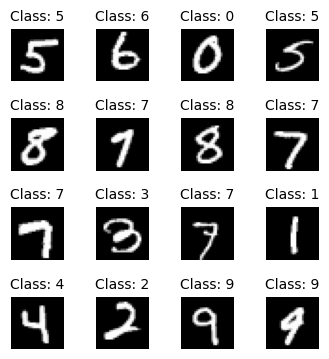

In [28]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

In [29]:
loader = DataLoader(dataset, batch_size=2, shuffle=True)
x, y = next(iter(loader))

In [30]:
x.shape, y.shape, y

(torch.Size([2, 784]), torch.Size([2]), tensor([4, 8]))

In [31]:
y.view(-1,1).shape

torch.Size([2, 1])

In [32]:
x.view(2, 1, 28, 28).shape

torch.Size([2, 1, 28, 28])

In [33]:
# x.view(x[0].size(0), -1)

## Select a device

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cpu


## Define the model

In [35]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConditionalMADE(nn.Module):
    def __init__(
        self,
        input_size=784,
        cond_size=10,
        hidden_sizes=[500, 500],
        natural_ordering=True,
    ):
        """
        Multi-layer conditional MADE (Germain et al. 2015)

        input_size: number of x dimensions (e.g. 784)
        cond_size: size of conditional vector (e.g. 10 for MNIST one-hot)
        hidden_sizes: list defining the number of hidden units per layer
        natural_ordering: if True, degrees = [1..D], else random permutation
        """
        super().__init__()

        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_sizes = hidden_sizes
        self.n_hidden = len(hidden_sizes)

        # -------------------------------------------------
        # 1) Degree assignment for MADE
        # -------------------------------------------------
        if natural_ordering:
            self.input_degrees = torch.arange(1, input_size + 1)
        else:
            self.input_degrees = torch.randperm(input_size) + 1

        # hidden layer degrees (each layer chooses degrees 1..input_size-1)
        self.hidden_degrees = []
        for h in hidden_sizes:
            self.hidden_degrees.append(
                torch.randint(1, input_size, (h,))
            )

        # output degrees = 1..D
        self.output_degrees = torch.arange(1, input_size + 1)

        # -------------------------------------------------
        # 2) Build linear layers (input + cond)
        # -------------------------------------------------
        layers = []
        layer_input_size = input_size + cond_size

        for h in hidden_sizes:
            layers.append(nn.Linear(layer_input_size, h))
            layer_input_size = h

        layers.append(nn.Linear(layer_input_size, input_size))  # output layer

        self.layers = nn.ModuleList(layers)

        # -------------------------------------------------
        # 3) Construct masks
        # -------------------------------------------------
        self.masks = self.build_masks()


    # -----------------------------------------------------
    # Build MADE masks following the exact paper
    # -----------------------------------------------------
    def build_masks(self):
        masks = []
        degrees_prev = torch.cat([torch.zeros(self.cond_size), self.input_degrees])

        # hidden layers
        for l, h_degrees in enumerate(self.hidden_degrees):
            mask = (degrees_prev[:, None] <= h_degrees[None, :]).float()
            masks.append(mask)
            degrees_prev = h_degrees

        # output layer mask
        mask_out = (degrees_prev[:, None] < self.output_degrees[None, :]).float()
        masks.append(mask_out)

        return masks


    # -----------------------------------------------------
    # Forward pass with masked weights
    # -----------------------------------------------------
    def forward(self, x, y_cond):
        """
        x:   [B, D]
        y:   [B, cond_size] (already one-hot encoded)
        """
        h = torch.cat([x, y_cond], dim=-1)

        for layer, mask in zip(self.layers, self.masks):
            W = layer.weight * mask.T
            h = F.linear(h, W, layer.bias)
            if layer is not self.layers[-1]:
                h = F.relu(h)

        return h  # logits


    # -----------------------------------------------------
    # Autoregressive sampling
    # -----------------------------------------------------
    @torch.no_grad()
    def sample(self, y_cond, device='cpu'):
        batch = y_cond.size(0)
        x = torch.zeros(batch, self.input_size, device=device)

        for i in range(self.input_size):
            logits = self.forward(x, y_cond)
            probs = torch.sigmoid(logits[:, i])
            x[:, i] = torch.bernoulli(probs)

        return x


## Instantiate models and optimizers

In [46]:
# TODO: Define the hyperparameters here.
input_dim = 28*28
hidden_layers = 2
hidden_dim = [10000,10000]
actv = "relu"
grad_clip = 5.0
n_mixtures = 10
lr = 1e-3

# Instantiate the model and optimizer here
model = ConditionalMADE(input_size=input_dim,
                        cond_size=10,
                        hidden_sizes=hidden_dim,
                        natural_ordering=True)
optimizer = optim.Adam(model.parameters(), lr=lr)

## Train the model

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_made(name, model, dataloader, max_patience, epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # NLL for Bernoulli output
    wandb.watch(model, log="all")

    nll_his = []
    best_nll = 1000.
    patience = 0
    
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}"):
            x = x.to(device)
            
            y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
            optimizer.zero_grad()
            logits = model(x, y_cond)
            loss = criterion(logits, x)  # NLL
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
        wandb.log({"epoch": epoch + 1, "loss": loss.item()})
        nll_his.append(loss.item())
        if epoch == 0:
            print('saved!')
            torch.save(model.state_dict(), f"{name}.pth")
            best_nll = loss
        else:
            if loss < best_nll:
                print('saved!')
                torch.save(model.state_dict(), f"{name}.pth")
                best_nll = loss
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch}: NLL loss = {epoch_loss:.4f}")

    return nll_his

In [49]:
# usage
# training parameters
epochs = 100
batch_size = 128
lr = 1e-3
max_patience = 3


train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
wandb.login(key="9bf31a65f3249f4d45183b47993a4fdc3328db1f")
wandb_logger = wandb.init(project="GenAI-Assignment-phase1", name="made_10000",
                         config = {
                        "learning_rate": lr,
                        "batch_size": batch_size,
                        "optimizer": "adam",
                        "epochs": epochs,
                        "model_architecture": "MADE",
                         "hidden_layers": hidden_dim }) 
loss_history = train_made("made_mnist-v4", model, train_loader, 
                          max_patience, epochs=epochs, lr=lr, device='cpu')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/100: 100%|██████████| 469/469 [34:22<00:00,  4.40s/it]


saved!
Epoch 1: NLL loss = 0.1210


Epoch 2/100: 100%|██████████| 469/469 [35:55<00:00,  4.60s/it]


saved!
Epoch 2: NLL loss = 0.0722


Epoch 3/100: 100%|██████████| 469/469 [36:14<00:00,  4.64s/it]


saved!
Epoch 3: NLL loss = 0.0679


Epoch 4/100: 100%|██████████| 469/469 [36:07<00:00,  4.62s/it]


saved!
Epoch 4: NLL loss = 0.0661


Epoch 5/100: 100%|██████████| 469/469 [36:31<00:00,  4.67s/it]


Epoch 5: NLL loss = 0.0650


Epoch 6/100: 100%|██████████| 469/469 [36:47<00:00,  4.71s/it]


saved!
Epoch 6: NLL loss = 0.0643


Epoch 7/100: 100%|██████████| 469/469 [36:31<00:00,  4.67s/it]


saved!
Epoch 7: NLL loss = 0.0638


Epoch 8/100: 100%|██████████| 469/469 [36:10<00:00,  4.63s/it]


saved!
Epoch 8: NLL loss = 0.0634


Epoch 9/100:  67%|██████▋   | 312/469 [24:24<12:17,  4.69s/it]


KeyboardInterrupt: 

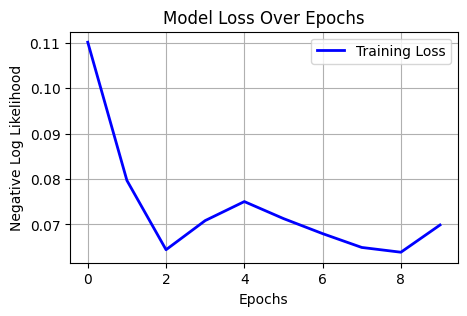

In [50]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)

plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.grid(True)
plt.show()

## [Optional] Save and/or load the model

In [51]:
## Optional TODO: Save the model if you want to store your work on disk and load it later
torch.save(model.state_dict(), "made_mnist_10k.pth")
wandb.save("made_mnist_10k.pth")
# loaded_model = ConditionalMADE(hidden_sizes = hidden_dim)
# loaded_model.load_state_dict(torch.load("made_mnist.pth"))

['/kaggle/working/wandb/run-20251130_162503-ihytmdwg/files/made_mnist_10k.pth']

## Write the generation function

## Generate some images and display them

ValueError: num must be an integer with 1 <= num <= 9, not 10

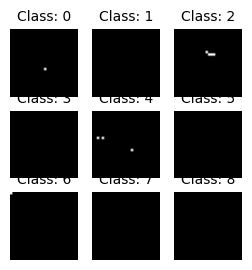

In [53]:
def generate(y: torch.Tensor) -> torch.Tensor:
    y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
    model.eval()
    new_x = model.sample(y_cond)
    return new_x
    
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for i in range(10)], dtype=torch.long)
x = generate(y)
show_images(x, y)

In [54]:
# log images in wandb
x = x.view(x.shape[0], 1, 28, 28)
if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
    
batch_size = x.shape[0]
# Draw a grid or images
wandb_image_list = []
sample_table = wandb.Table(columns=["images", "labels"])
for i in range(batch_size):
    caption_text = f"Label: {y[i].item()}"
    wandb_image = wandb.Image(x[i], caption=caption_text)
    wandb_image_list.append(wandb_image)
# 4. Log the entire list in a single wandb.log() call
wandb.log({"Generated Samples Grid": wandb_image_list})
wandb_logger.finish()

epoch,▁▂▃▄▅▆▇█
loss,█▅▄▃▃▁▁▁
epoch,9
loss,0.06209


## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).